In [1]:
from neo4j import GraphDatabase

url = "bolt://localhost:7687"
username = "neo4j"
password = "letmein"

# Connect to Neo4j
driver = GraphDatabase.driver(url, auth=(username, password))

In [2]:
import pandas as pd

def run_query(query, params={}):
    with driver.session() as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [3]:
# Create feature set
run_query("""
MATCH (s1:Stream)-[:SHARED_AUDIENCE]->(s2:Stream)
WITH s1, s2
ORDER BY s1.id,s2.id
WHERE rand() <= 0.9
MERGE (s1)-[:FEATURE_REL]->(s2);
""")

""


In [4]:
# Create test/train set
train_test_size = run_query("""
MATCH (s1)-[:SHARED_AUDIENCE]->(s2)
WHERE NOT EXISTS {(s1)-[:FEATURE_REL]->(s2)}
MERGE (s1)-[r:TEST_TRAIN]->(s2)
RETURN count(r) AS result;
""")

print(train_test_size)

   result
0   13082


In [5]:
# Create negative test/train pairs
run_query("""
MATCH (s1:Stream),(s2:Stream)
WHERE NOT EXISTS {(s1)-[:SHARED_AUDIENCE]-(s2)} AND s1 < s2
WITH s1,s2
LIMIT 13082
MERGE (s1)-[:NEGATIVE_TEST_TRAIN]->(s2);
""")

""


In [6]:
# Network distance
run_query("""
MATCH (s1)-[r:TEST_TRAIN|NEGATIVE_TEST_TRAIN]->(s2)
MATCH p = shortestPath((s1)-[:FEATURE_REL*]-(s2))
WITH r, length(p) AS networkDistance
SET r.networkDistance = networkDistance
""")

""


In [7]:
# Preferential attachment
run_query("""
MATCH (s1:Stream)-[r:TEST_TRAIN|NEGATIVE_TEST_TRAIN]->(s2)
WITH r, size((s1)-[:FEATURE_REL]-()) * size((s2)-[:FEATURE_REL]-()) AS preferentialAttachment
SET r.preferentialAttachment = preferentialAttachment
""")


""


In [8]:
# Common neighbors
run_query("""
MATCH (s1:Stream)-[r:TEST_TRAIN|NEGATIVE_TEST_TRAIN]->(s2)
OPTIONAL MATCH (s1)-[:FEATURE_REL]-(neighbor)-[:FEATURE_REL]-(s2)
WITH r, count(distinct neighbor) AS commonNeighbor
SET r.commonNeighbor = commonNeighbor
""")

""


In [9]:
# Adamic Adar
run_query("""
MATCH (s1:Stream)-[r:TEST_TRAIN|NEGATIVE_TEST_TRAIN]->(s2:Stream)
OPTIONAL MATCH (s1)-[:FEATURE_REL]-(neighbor)-[:FEATURE_REL]-(s2)
WITH r, collect(distinct neighbor) AS commonNeighbors
UNWIND commonNeighbors AS cn
WITH r, size((cn)-[:FEATURE_REL]-()) AS neighborDegree
WITH r, sum(1 / log(neighborDegree)) AS adamicAdar
SET r.adamicAdar = adamicAdar;
""")

""


In [10]:
# Clustering coefficient of common neighbors
run_query("""
MATCH (s1:Stream)-[r:TEST_TRAIN|NEGATIVE_TEST_TRAIN]->(s2:Stream)
OPTIONAL MATCH (s1)-[:FEATURE_REL]-(neighbor)-[:FEATURE_REL]-(s2)
WITH r, collect(distinct neighbor) AS commonNeighbors, 
        count(distinct neighbor) AS commonNeighborCount
OPTIONAL MATCH (x)-[cr:FEATURE_REL]->(y)
WHERE x IN commonNeighbors AND y IN commonNeighbors
WITH r, commonNeighborCount, count(cr) AS commonNeighborRels
WITH r, CASE WHEN commonNeighborCount < 2 THEN 0 ELSE
   toFloat(commonNeighborRels) / (commonNeighborCount * 
                 (commonNeighborCount - 1) / 2) END as clusteringCoefficient
SET r.clusteringCoefficient = clusteringCoefficient
""")

""


In [11]:
# Fetch features
data = run_query("""
MATCH (s1)-[r:TEST_TRAIN|NEGATIVE_TEST_TRAIN]->(s2)
WITH r.networkDistance AS networkDistance,
     r.preferentialAttachment AS preferentialAttachment,
     r.commonNeighbor AS commonNeighbor,
     r.adamicAdar  AS adamicAdar,
     r.clusteringCoefficient  AS clusteringCoefficient,
     CASE WHEN r:TEST_TRAIN THEN 1 ELSE 0 END as output
RETURN networkDistance, preferentialAttachment, commonNeighbor,
       adamicAdar, clusteringCoefficient, output     
""")

In [12]:
data.head()

,networkDistance,preferentialAttachment,commonNeighbor,adamicAdar,clusteringCoefficient,output
0,2.0,26820,26,6.163399,0.787692,1
1,2.0,368775,249,46.546615,0.449799,1
2,2.0,49170,49,8.592873,0.823980,1
3,2.0,94615,35,6.403017,0.655462,1
4,2.0,90145,74,14.509021,0.553499,1


In [13]:
data.describe()

,networkDistance,preferentialAttachment,commonNeighbor,adamicAdar,clusteringCoefficient,output
count,26102.000000,2.616400e+04,26164.000000,24668.000000,26164.000000,26164.00000
mean,2.055513,3.381520e+04,40.917864,8.097444,0.718954,0.50000
std,0.231479,5.907992e+04,53.099901,10.182073,0.281442,0.50001
min,2.000000,0.000000e+00,0.000000,0.133612,0.000000,0.00000
25%,2.000000,5.016000e+03,6.000000,1.328216,0.670995,0.00000
50%,2.000000,1.432900e+04,21.000000,4.368129,0.813187,0.50000
75%,2.000000,4.036200e+04,54.000000,10.822366,0.888889,1.00000
max,4.000000,2.734080e+06,1177.000000,289.355637,1.000000,1.00000


In [14]:
data['networkDistance'].fillna(4, inplace=True)
data['adamicAdar'].fillna(8.097444, inplace=True)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = data.drop("output", axis=1)
y = data["output"].to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [16]:
from sklearn.metrics import classification_report

y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2578
           1       0.93      0.91      0.92      2655

    accuracy                           0.92      5233
   macro avg       0.92      0.92      0.92      5233
weighted avg       0.92      0.92      0.92      5233



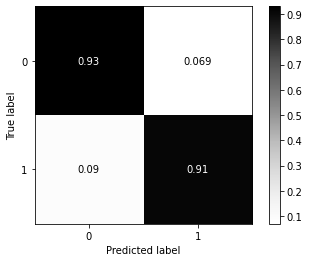

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", cmap="Greys")

In [18]:
def feature_importance(columns, classifier):        
    features = list(zip(columns, classifier.feature_importances_))
    sorted_features = sorted(features, key = lambda x: x[1]*-1)
    
    keys = [value[0] for value in sorted_features]
    values = [value[1] for value in sorted_features]
    return pd.DataFrame(data={'feature': keys, 'value': values})

feature_importance(X.columns, rfc)

,feature,value
0,adamicAdar,0.348872
1,commonNeighbor,0.266738
2,preferentialAttachment,0.256368
3,clusteringCoefficient,0.123113
4,networkDistance,0.004909
